In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
import matplotlib.pyplot as plt
import matplotlib

def plot_loss(layer1, epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, layer1)
    #plt.plot(epoche_range, layer2)
    #plt.plot(epoche_range, fc)
    #plt.legend(['train loss', 'validation loss'], loc='best')
    plt.show()

In [4]:
def data_loader(dataset, batch_size, shuffle=False):
  return DataLoader(dataset, batch_size, shuffle=shuffle)

In [5]:
class Dataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data)
        self.targets = torch.tensor(targets)
           
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):  # get the label and data by index
        x = self.data[index]
        y = self.targets[index]
        return x, y

In [6]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

In [7]:
train_loader = data_loader(train_dataset, 120, shuffle=True)
test_loader = data_loader(test_dataset, 30, shuffle=True)

In [8]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [9]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn  = nn.CrossEntropyLoss()

In [10]:
num_epochs = 500

In [11]:
# Train the model
total_step = len(train_loader)
results = []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        inputs = inputs.float().to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        results.append(loss.item())
        #if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))

Epoch [1/500], Loss: 1.1142
Epoch [2/500], Loss: 1.0535
Epoch [3/500], Loss: 0.9981
Epoch [4/500], Loss: 0.9445
Epoch [5/500], Loss: 0.8913
Epoch [6/500], Loss: 0.8435
Epoch [7/500], Loss: 0.8055
Epoch [8/500], Loss: 0.7772
Epoch [9/500], Loss: 0.7543
Epoch [10/500], Loss: 0.7335
Epoch [11/500], Loss: 0.7148
Epoch [12/500], Loss: 0.7001
Epoch [13/500], Loss: 0.6889
Epoch [14/500], Loss: 0.6783
Epoch [15/500], Loss: 0.6666
Epoch [16/500], Loss: 0.6552
Epoch [17/500], Loss: 0.6452
Epoch [18/500], Loss: 0.6355
Epoch [19/500], Loss: 0.6252
Epoch [20/500], Loss: 0.6160
Epoch [21/500], Loss: 0.6098
Epoch [22/500], Loss: 0.6053
Epoch [23/500], Loss: 0.6013
Epoch [24/500], Loss: 0.5975
Epoch [25/500], Loss: 0.5938
Epoch [26/500], Loss: 0.5921
Epoch [27/500], Loss: 0.5917
Epoch [28/500], Loss: 0.5906
Epoch [29/500], Loss: 0.5889
Epoch [30/500], Loss: 0.5871
Epoch [31/500], Loss: 0.5849
Epoch [32/500], Loss: 0.5827
Epoch [33/500], Loss: 0.5813
Epoch [34/500], Loss: 0.5808
Epoch [35/500], Loss: 0

In [12]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 99.16666666666667 %


In [13]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 96.66666666666667 %


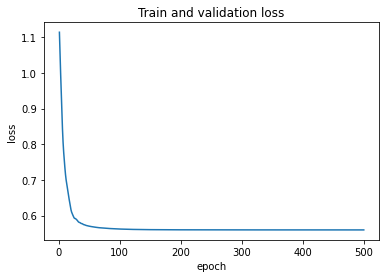

In [14]:
plot_loss(results, num_epochs)

In [15]:
class Model1(nn.Module):
    def __init__(self, input_dim):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)
        
    def forward(self, x, training_layer="fc3"):
        if training_layer == "fc1":
          x = F.relu(self.fc1(x))
        elif training_layer == "fc2":
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
        elif training_layer == "fc3":
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.softmax(self.fc3(x), dim=1)
        return x

In [16]:
def pairwise_distances(x):
    #x should be two dimensional
    instances_norm = torch.sum(x**2,-1).reshape((-1,1))
    return -2*torch.mm(x.float(),x.t().float()) + instances_norm + instances_norm.t().float()
    
def calculate_gram_mat(x, sigma):
    dist= pairwise_distances(x)
    return torch.exp(-dist /sigma)


def reyi_entropy(x,sigma):
    alpha = 1.001
    k = calculate_gram_mat(x,sigma)
    k = k/torch.trace(k) 
    eigv = torch.abs(torch.symeig(k, eigenvectors=True)[0])
    eig_pow = eigv**alpha
    entropy = (1/(1-alpha))*torch.log2(torch.sum(eig_pow))
    return entropy


def joint_entropy(x,y,s_x,s_y):
    alpha = 1.001
    x = calculate_gram_mat(x,s_x)
    y = calculate_gram_mat(y,s_y)
    k = torch.mul(x,y)
    k = k/torch.trace(k)
    eigv = torch.abs(torch.symeig(k, eigenvectors=True)[0])
    eig_pow =  eigv**alpha
    entropy = (1/(1-alpha))*torch.log2(torch.sum(eig_pow))

    return entropy


def calculate_MI(x,y,s_x,s_y):
    Hx = reyi_entropy(x,sigma=s_x)
    Hy = reyi_entropy(y,sigma=s_y)
    Hxy = joint_entropy(x,y,s_x,s_y)
    Ixy = Hx+Hy-Hxy
    normlize = Ixy/(torch.max(Hx,Hy)+1e-16)
    return normlize

In [17]:
def loss_fn(inputs, outputs, targets, name):
    #outputs_2d = outputs.view(outputs.shape[0], -1)
    #print("output_2d shape",outputs_2d.shape)
    #targets_2d = torch.unsqueeze(targets, dim = 1)
    #error = rmse(outputs, targets)
    if name == 'cross_entropy':
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, targets)    
    if name == 'MI':
        outputs_2d = outputs.view(outputs.shape[0], -1)
        targets_2d = targets.view(targets.shape[0], -1)
        loss = -calculate_MI(outputs_2d,targets_2d,s_x=2,s_y=1)
    if name == "BI":
        outputs_2d = outputs.view(outputs.shape[0], -1)
        inputs_2d = inputs.view(inputs.shape[0], -1)
        targets_2d = targets.view(targets.shape[0], -1)
        loss = calculate_MI(inputs_2d, outputs_2d, s_x=2, s_y=1) - calculate_MI(outputs_2d,targets_2d,s_x=2,s_y=1)
    return loss

In [154]:
def layerwise_train_MIMIMI(model, num_epochs, optimizer_list, criterion):
    #train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    model.train()
    for param in model.parameters(): 
        param.requires_grad = False
    fc1_MI = []
    fc2_MI = []
    fc3_MI = []
    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[0]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc1")
            #print(type(outputs),type(images), type(labels))
            loss = criterion(images, outputs, labels, "MI")
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            MI = -loss.item()
            sum_MI += MI

        fc1_MI.append(sum_MI/total_step)
        
        print ('Epoch [{}/{}], fc1 MI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[1]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc2")
            loss = criterion(images, outputs, labels, "MI")
            MI = -loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sum_MI += MI
        fc2_MI.append(sum_MI/total_step)
        print ('Epoch [{}/{}], fc2 MI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False

    #traning fc3
    print("Training fc3")
    for name, param in model.fc3.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[2]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc3")
            loss = criterion(images, outputs, labels, 'MI')
            MI = -loss.item()
            sum_MI += MI
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
        fc3_MI.append(sum_MI/total_step)
        print ('Epoch [{}/{}], fc3 MI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc3.named_parameters():
        param.requires_grad = False
    
    return fc1_MI, fc2_MI, fc3_MI

In [228]:
model1 = Model1(X_train.shape[1]).to(device)
# Loss and optimizer
criterion1 = loss_fn
optimizer1 = [torch.optim.Adam(model1.parameters(), lr=0.001), torch.optim.Adam(model1.parameters(), lr=0.0005), torch.optim.Adam(model1.parameters(), lr=0.01)]

In [229]:
num_epochs = 500
fc1, fc2, fc3 = layerwise_train_MIMIMI(model1, num_epochs, optimizer1, criterion1)

Training fc1
Epoch [1/500], fc1 MI: 0.2964
Epoch [2/500], fc1 MI: 0.2971
Epoch [3/500], fc1 MI: 0.2977
Epoch [4/500], fc1 MI: 0.2983
Epoch [5/500], fc1 MI: 0.2988
Epoch [6/500], fc1 MI: 0.2997
Epoch [7/500], fc1 MI: 0.3003
Epoch [8/500], fc1 MI: 0.3010
Epoch [9/500], fc1 MI: 0.3016
Epoch [10/500], fc1 MI: 0.3021
Epoch [11/500], fc1 MI: 0.3028
Epoch [12/500], fc1 MI: 0.3034
Epoch [13/500], fc1 MI: 0.3041
Epoch [14/500], fc1 MI: 0.3047
Epoch [15/500], fc1 MI: 0.3056
Epoch [16/500], fc1 MI: 0.3060
Epoch [17/500], fc1 MI: 0.3068
Epoch [18/500], fc1 MI: 0.3075
Epoch [19/500], fc1 MI: 0.3082
Epoch [20/500], fc1 MI: 0.3088
Epoch [21/500], fc1 MI: 0.3096
Epoch [22/500], fc1 MI: 0.3102
Epoch [23/500], fc1 MI: 0.3109
Epoch [24/500], fc1 MI: 0.3114
Epoch [25/500], fc1 MI: 0.3122
Epoch [26/500], fc1 MI: 0.3129
Epoch [27/500], fc1 MI: 0.3138
Epoch [28/500], fc1 MI: 0.3145
Epoch [29/500], fc1 MI: 0.3152
Epoch [30/500], fc1 MI: 0.3158
Epoch [31/500], fc1 MI: 0.3168
Epoch [32/500], fc1 MI: 0.3172
Epoc

In [230]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))

Accuracy of the network on the test: 97.5 %


In [231]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))

Accuracy of the network on the test: 100.0 %


The same training setting will lead to different performance. MI could be too random

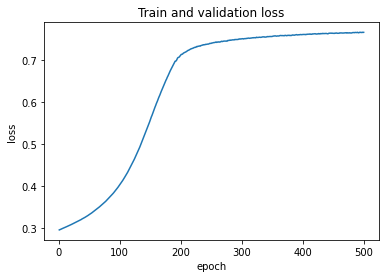

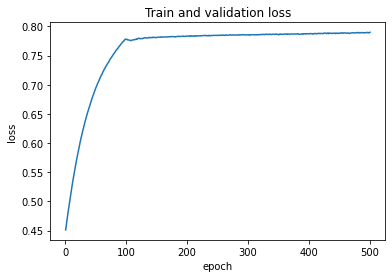

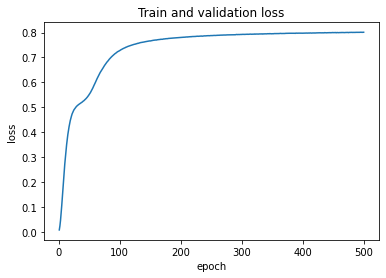

In [232]:
plot_loss(fc1, num_epochs)
plot_loss(fc2, num_epochs)
plot_loss(fc3, num_epochs)

In [18]:
def layerwise_train_MIMICE(model, num_epochs, optimizer_list, criterion):
    #train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    model.train()
    for param in model.parameters(): 
        param.requires_grad = False
    fc1_MI = []
    fc2_MI = []
    fc3_MI = []
    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[0]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc1")
            #print(type(outputs),type(images), type(labels))
            loss = criterion(images, outputs, labels, "MI")
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            MI = -loss.item()
            sum_MI += MI

        fc1_MI.append(sum_MI/total_step)
        
        print ('Epoch [{}/{}], fc1 MI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[1]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc2")
            loss = criterion(images, outputs, labels, "MI")
            MI = -loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sum_MI += MI
        fc2_MI.append(sum_MI/total_step)
        print ('Epoch [{}/{}], fc2 MI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False

    #traning fc3
    print("Training fc3")
    for name, param in model.fc3.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[2]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc3")
            loss = criterion(images, outputs, labels, 'cross_entropy')
            MI = loss.item()
            sum_MI += MI
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
        fc3_MI.append(sum_MI/total_step)
        print ('Epoch [{}/{}], fc3 CE: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc3.named_parameters():
        param.requires_grad = False
    
    return fc1_MI, fc2_MI, fc3_MI

In [19]:
model2 = Model1(X_train.shape[1]).to(device)
# Loss and optimizer
criterion2 = loss_fn
optimizer2 = [torch.optim.Adam(model2.parameters(), lr=0.001), torch.optim.Adam(model2.parameters(), lr=0.001), torch.optim.Adam(model2.parameters(), lr=0.01)]

In [20]:
num_epochs = 500
fc1, fc2, fc3 = layerwise_train_MIMICE(model2, num_epochs, optimizer2, criterion2)

Training fc1
Epoch [1/500], fc1 MI: 0.2855
Epoch [2/500], fc1 MI: 0.2862
Epoch [3/500], fc1 MI: 0.2864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:3029.)
  from ipykernel import kernelapp as app


Epoch [4/500], fc1 MI: 0.2870
Epoch [5/500], fc1 MI: 0.2875
Epoch [6/500], fc1 MI: 0.2879
Epoch [7/500], fc1 MI: 0.2884
Epoch [8/500], fc1 MI: 0.2888
Epoch [9/500], fc1 MI: 0.2894
Epoch [10/500], fc1 MI: 0.2898
Epoch [11/500], fc1 MI: 0.2903
Epoch [12/500], fc1 MI: 0.2906
Epoch [13/500], fc1 MI: 0.2912
Epoch [14/500], fc1 MI: 0.2917
Epoch [15/500], fc1 MI: 0.2920
Epoch [16/500], fc1 MI: 0.2926
Epoch [17/500], fc1 MI: 0.2930
Epoch [18/500], fc1 MI: 0.2936
Epoch [19/500], fc1 MI: 0.2941
Epoch [20/500], fc1 MI: 0.2945
Epoch [21/500], fc1 MI: 0.2951
Epoch [22/500], fc1 MI: 0.2956
Epoch [23/500], fc1 MI: 0.2960
Epoch [24/500], fc1 MI: 0.2964
Epoch [25/500], fc1 MI: 0.2970
Epoch [26/500], fc1 MI: 0.2977
Epoch [27/500], fc1 MI: 0.2981
Epoch [28/500], fc1 MI: 0.2987
Epoch [29/500], fc1 MI: 0.2992
Epoch [30/500], fc1 MI: 0.2996
Epoch [31/500], fc1 MI: 0.3003
Epoch [32/500], fc1 MI: 0.3007
Epoch [33/500], fc1 MI: 0.3013
Epoch [34/500], fc1 MI: 0.3018
Epoch [35/500], fc1 MI: 0.3026
Epoch [36/500]

In [21]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train: {} %'.format(100 * correct / total))

Accuracy of the network on the train: 96.66666666666667 %


In [22]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))

Accuracy of the network on the test: 100.0 %


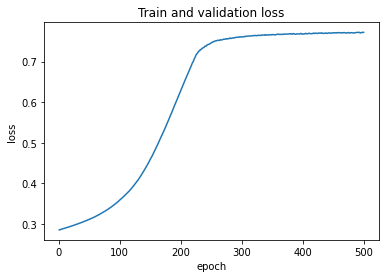

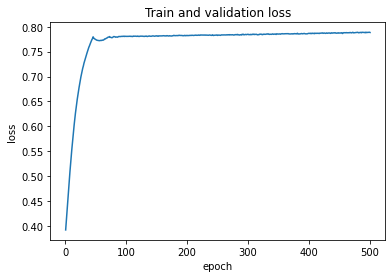

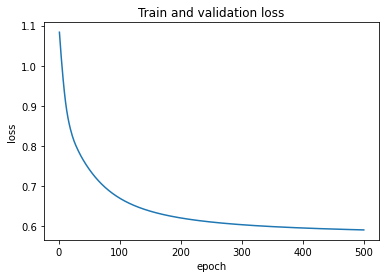

In [23]:
plot_loss(fc1, num_epochs)
plot_loss(fc2, num_epochs)
plot_loss(fc3, num_epochs)

In [24]:
def layerwise_train_BIMIMI(model, num_epochs, optimizer_list, criterion):
    #train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    model.train()
    for param in model.parameters(): 
        param.requires_grad = False
    fc1_MI = []
    fc2_MI = []
    fc3_MI = []
    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[0]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc1")
            #print(type(outputs),type(images), type(labels))
            loss = criterion(images, outputs, labels, "BI")
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            MI = loss.item()
            sum_MI += MI

        fc1_MI.append(sum_MI/total_step)
        
        print ('Epoch [{}/{}], fc1 BI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[1]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc2")
            loss = criterion(images, outputs, labels, "MI")
            MI = -loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sum_MI += MI
        fc2_MI.append(sum_MI/total_step)
        print ('Epoch [{}/{}], fc2 MI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False

    #traning fc3
    print("Training fc3")
    for name, param in model.fc3.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[2]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc3")
            loss = criterion(images, outputs, labels, 'MI')
            MI = -loss.item()
            sum_MI += MI
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
        fc3_MI.append(sum_MI/total_step)
        print ('Epoch [{}/{}], fc3 MI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc3.named_parameters():
        param.requires_grad = False
    
    return fc1_MI, fc2_MI, fc3_MI

In [439]:
model3 = Model1(X_train.shape[1]).to(device)
# Loss and optimizer
criterion3 = loss_fn
optimizer3 = [torch.optim.Adam(model3.parameters(), lr=0.01), torch.optim.Adam(model3.parameters(), lr=0.0005), torch.optim.Adam(model3.parameters(), lr=0.005)]
num_epochs = 500
fc1, fc2, fc3 = layerwise_train_BIMIMI(model3, num_epochs, optimizer3, criterion3)

Training fc1
Epoch [1/500], fc1 BI: 0.3518
Epoch [2/500], fc1 BI: 0.3487
Epoch [3/500], fc1 BI: 0.3459
Epoch [4/500], fc1 BI: 0.3433
Epoch [5/500], fc1 BI: 0.3410
Epoch [6/500], fc1 BI: 0.3389
Epoch [7/500], fc1 BI: 0.3368
Epoch [8/500], fc1 BI: 0.3350
Epoch [9/500], fc1 BI: 0.3334
Epoch [10/500], fc1 BI: 0.3322
Epoch [11/500], fc1 BI: 0.3307
Epoch [12/500], fc1 BI: 0.3296
Epoch [13/500], fc1 BI: 0.3285
Epoch [14/500], fc1 BI: 0.3278
Epoch [15/500], fc1 BI: 0.3268
Epoch [16/500], fc1 BI: 0.3259
Epoch [17/500], fc1 BI: 0.3252
Epoch [18/500], fc1 BI: 0.3246
Epoch [19/500], fc1 BI: 0.3240
Epoch [20/500], fc1 BI: 0.3233
Epoch [21/500], fc1 BI: 0.3228
Epoch [22/500], fc1 BI: 0.3221
Epoch [23/500], fc1 BI: 0.3216
Epoch [24/500], fc1 BI: 0.3211
Epoch [25/500], fc1 BI: 0.3207
Epoch [26/500], fc1 BI: 0.3202
Epoch [27/500], fc1 BI: 0.3197
Epoch [28/500], fc1 BI: 0.3193
Epoch [29/500], fc1 BI: 0.3190
Epoch [30/500], fc1 BI: 0.3184
Epoch [31/500], fc1 BI: 0.3179
Epoch [32/500], fc1 BI: 0.3172
Epoc

Accuracy of the network on the train: 65.0 %
Accuracy of the network on the test: 73.33333333333333 %


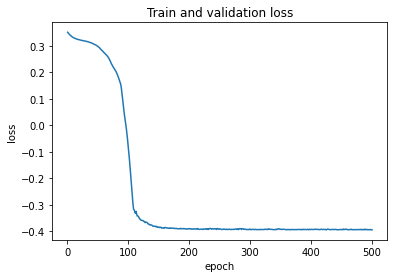

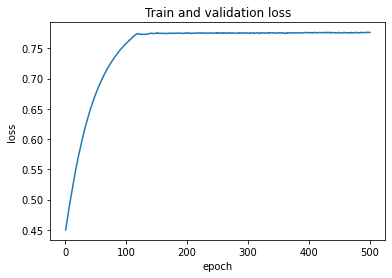

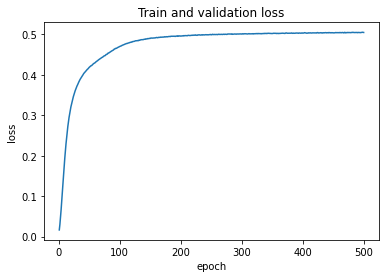

In [440]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train: {} %'.format(100 * correct / total))
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))
plot_loss(fc1, num_epochs)
plot_loss(fc2, num_epochs)
plot_loss(fc3, num_epochs)

In [75]:
def layerwise_train_BIMICE(model, num_epochs, optimizer_list, criterion):
    #train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    model.train()
    for param in model.parameters(): 
        param.requires_grad = False
    fc1_MI = []
    fc2_MI = []
    fc3_MI = []
    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[0]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc1")
            #print(type(outputs),type(images), type(labels))
            loss = criterion(images, outputs, labels, "BI")
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            MI = loss.item()
            sum_MI += MI

        fc1_MI.append(sum_MI/total_step)
        
        print ('Epoch [{}/{}], fc1 BI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[1]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc2")
            loss = criterion(images, outputs, labels, "MI")
            MI = -loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sum_MI += MI
        fc2_MI.append(sum_MI/total_step)
        print ('Epoch [{}/{}], fc2 MI: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False

    #traning fc3
    print("Training fc3")
    for name, param in model.fc3.named_parameters():
        param.requires_grad = True
    optimizer = optimizer_list[2]
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, training_layer="fc3")
            loss = criterion(images, outputs, labels, 'cross_entropy')
            MI = loss.item()
            sum_MI += MI
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
        fc3_MI.append(sum_MI/total_step)
        print ('Epoch [{}/{}], fc3 CE: {:.4f}' 
                   .format(epoch+1, num_epochs, sum_MI/total_step))
    for name, param in model.fc3.named_parameters():
        param.requires_grad = False
    
    return fc1_MI, fc2_MI, fc3_MI

In [380]:
model4 = Model1(X_train.shape[1]).to(device)
# Loss and optimizer
criterion4 = loss_fn
optimizer4 = [torch.optim.Adam(model4.parameters(), lr=0.01), torch.optim.Adam(model4.parameters(), lr=0.001), torch.optim.Adam(model4.parameters(), lr=0.1)]
num_epochs = 500
fc1, fc2, fc3 = layerwise_train_BIMICE(model4, num_epochs, optimizer4, criterion4)

Training fc1
Epoch [1/500], fc1 BI: 0.3475
Epoch [2/500], fc1 BI: 0.3449
Epoch [3/500], fc1 BI: 0.3425
Epoch [4/500], fc1 BI: 0.3403
Epoch [5/500], fc1 BI: 0.3383
Epoch [6/500], fc1 BI: 0.3366
Epoch [7/500], fc1 BI: 0.3351
Epoch [8/500], fc1 BI: 0.3336
Epoch [9/500], fc1 BI: 0.3322
Epoch [10/500], fc1 BI: 0.3310
Epoch [11/500], fc1 BI: 0.3298
Epoch [12/500], fc1 BI: 0.3289
Epoch [13/500], fc1 BI: 0.3278
Epoch [14/500], fc1 BI: 0.3267
Epoch [15/500], fc1 BI: 0.3259
Epoch [16/500], fc1 BI: 0.3250
Epoch [17/500], fc1 BI: 0.3241
Epoch [18/500], fc1 BI: 0.3234
Epoch [19/500], fc1 BI: 0.3227
Epoch [20/500], fc1 BI: 0.3219
Epoch [21/500], fc1 BI: 0.3213
Epoch [22/500], fc1 BI: 0.3208
Epoch [23/500], fc1 BI: 0.3200
Epoch [24/500], fc1 BI: 0.3192
Epoch [25/500], fc1 BI: 0.3186
Epoch [26/500], fc1 BI: 0.3180
Epoch [27/500], fc1 BI: 0.3174
Epoch [28/500], fc1 BI: 0.3165
Epoch [29/500], fc1 BI: 0.3158
Epoch [30/500], fc1 BI: 0.3150
Epoch [31/500], fc1 BI: 0.3141
Epoch [32/500], fc1 BI: 0.3134
Epoc

Accuracy of the network on the train: 95.83333333333333 %
Accuracy of the network on the test: 100.0 %


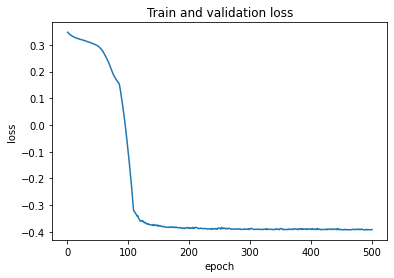

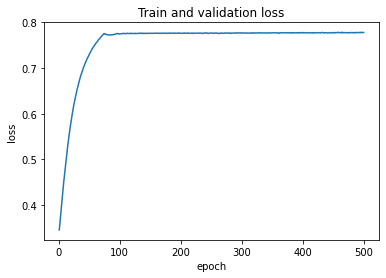

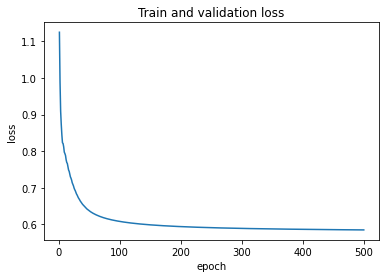

In [381]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train: {} %'.format(100 * correct / total))
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))
plot_loss(fc1, num_epochs)
plot_loss(fc2, num_epochs)
plot_loss(fc3, num_epochs)

In [151]:
class Model2(nn.Module):
    def __init__(self, input_dim):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)
        
    def forward(self, x, training_layer="fc3"):
        if training_layer == "fc1":
          x = self.fc1(x)
        elif training_layer == "fc2":
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
        elif training_layer == "fc3":
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.softmax(self.fc3(x), dim=1)
        return x

In [237]:
model5 = Model2(X_train.shape[1]).to(device)
# Loss and optimizer
criterion5 = loss_fn
optimizer5 = [torch.optim.Adam(model5.parameters(), lr=0.001), torch.optim.Adam(model5.parameters(), lr=0.0005), torch.optim.Adam(model5.parameters(), lr=0.05)]

In [238]:
num_epochs = 500
fc1, fc2, fc3 = layerwise_train_MIMIMI(model5, num_epochs, optimizer5, criterion5)

Training fc1
Epoch [1/500], fc1 MI: 0.2517
Epoch [2/500], fc1 MI: 0.2519
Epoch [3/500], fc1 MI: 0.2521
Epoch [4/500], fc1 MI: 0.2524
Epoch [5/500], fc1 MI: 0.2525
Epoch [6/500], fc1 MI: 0.2528
Epoch [7/500], fc1 MI: 0.2531
Epoch [8/500], fc1 MI: 0.2532
Epoch [9/500], fc1 MI: 0.2535
Epoch [10/500], fc1 MI: 0.2538
Epoch [11/500], fc1 MI: 0.2540
Epoch [12/500], fc1 MI: 0.2541
Epoch [13/500], fc1 MI: 0.2544
Epoch [14/500], fc1 MI: 0.2547
Epoch [15/500], fc1 MI: 0.2548
Epoch [16/500], fc1 MI: 0.2551
Epoch [17/500], fc1 MI: 0.2553
Epoch [18/500], fc1 MI: 0.2556
Epoch [19/500], fc1 MI: 0.2557
Epoch [20/500], fc1 MI: 0.2561
Epoch [21/500], fc1 MI: 0.2563
Epoch [22/500], fc1 MI: 0.2566
Epoch [23/500], fc1 MI: 0.2568
Epoch [24/500], fc1 MI: 0.2569
Epoch [25/500], fc1 MI: 0.2573
Epoch [26/500], fc1 MI: 0.2575
Epoch [27/500], fc1 MI: 0.2577
Epoch [28/500], fc1 MI: 0.2579
Epoch [29/500], fc1 MI: 0.2582
Epoch [30/500], fc1 MI: 0.2584
Epoch [31/500], fc1 MI: 0.2588
Epoch [32/500], fc1 MI: 0.2590
Epoc

In [239]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train: {} %'.format(100 * correct / total))

Accuracy of the network on the train: 97.5 %


In [240]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))

Accuracy of the network on the test: 100.0 %


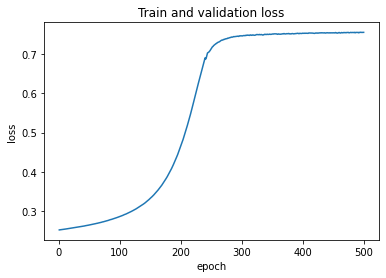

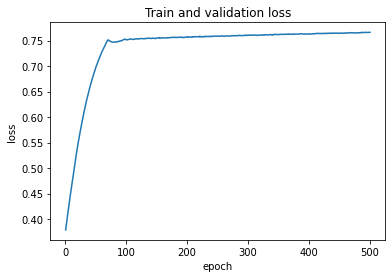

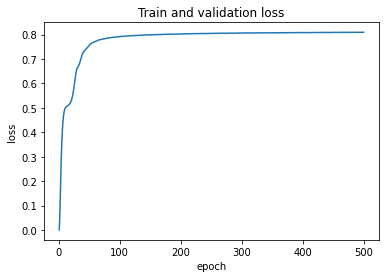

In [241]:
plot_loss(fc1, num_epochs)
plot_loss(fc2, num_epochs)
plot_loss(fc3, num_epochs)

In [265]:
model6 = Model2(X_train.shape[1]).to(device)
# Loss and optimizer
criterion6 = loss_fn
optimizer6 = [torch.optim.Adam(model6.parameters(), lr=0.001), torch.optim.Adam(model6.parameters(), lr=0.0005), torch.optim.Adam(model6.parameters(), lr=0.05)]
num_epochs = 500
fc1, fc2, fc3 = layerwise_train_MIMICE(model6, num_epochs, optimizer6, criterion6)

Training fc1
Epoch [1/500], fc1 MI: 0.2596
Epoch [2/500], fc1 MI: 0.2598
Epoch [3/500], fc1 MI: 0.2601
Epoch [4/500], fc1 MI: 0.2604
Epoch [5/500], fc1 MI: 0.2606
Epoch [6/500], fc1 MI: 0.2609
Epoch [7/500], fc1 MI: 0.2612
Epoch [8/500], fc1 MI: 0.2614
Epoch [9/500], fc1 MI: 0.2618
Epoch [10/500], fc1 MI: 0.2620
Epoch [11/500], fc1 MI: 0.2623
Epoch [12/500], fc1 MI: 0.2625
Epoch [13/500], fc1 MI: 0.2627
Epoch [14/500], fc1 MI: 0.2631
Epoch [15/500], fc1 MI: 0.2633
Epoch [16/500], fc1 MI: 0.2635
Epoch [17/500], fc1 MI: 0.2638
Epoch [18/500], fc1 MI: 0.2642
Epoch [19/500], fc1 MI: 0.2644
Epoch [20/500], fc1 MI: 0.2646
Epoch [21/500], fc1 MI: 0.2650
Epoch [22/500], fc1 MI: 0.2654
Epoch [23/500], fc1 MI: 0.2656
Epoch [24/500], fc1 MI: 0.2658
Epoch [25/500], fc1 MI: 0.2663
Epoch [26/500], fc1 MI: 0.2666
Epoch [27/500], fc1 MI: 0.2669
Epoch [28/500], fc1 MI: 0.2673
Epoch [29/500], fc1 MI: 0.2675
Epoch [30/500], fc1 MI: 0.2678
Epoch [31/500], fc1 MI: 0.2682
Epoch [32/500], fc1 MI: 0.2683
Epoc

Accuracy of the network on the train: 98.33333333333333 %
Accuracy of the network on the test: 100.0 %


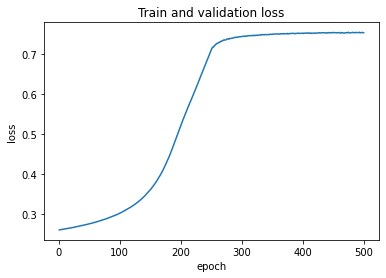

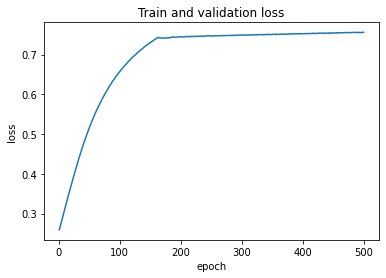

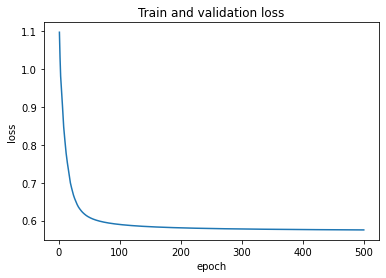

In [266]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model6(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train: {} %'.format(100 * correct / total))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model6(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))

plot_loss(fc1, num_epochs)
plot_loss(fc2, num_epochs)
plot_loss(fc3, num_epochs)

In [368]:
model7 = Model2(X_train.shape[1]).to(device)
# Loss and optimizer
criterion7 = loss_fn
optimizer7 = [torch.optim.Adam(model7.parameters(), lr=0.01), torch.optim.Adam(model7.parameters(), lr=0.0005), torch.optim.Adam(model7.parameters(), lr=0.05)]
num_epochs = 500
fc1, fc2, fc3 = layerwise_train_BIMIMI(model7, num_epochs, optimizer7, criterion7)

Training fc1
Epoch [1/500], fc1 BI: 0.3290
Epoch [2/500], fc1 BI: 0.3279
Epoch [3/500], fc1 BI: 0.3271
Epoch [4/500], fc1 BI: 0.3259
Epoch [5/500], fc1 BI: 0.3249
Epoch [6/500], fc1 BI: 0.3241
Epoch [7/500], fc1 BI: 0.3234
Epoch [8/500], fc1 BI: 0.3227
Epoch [9/500], fc1 BI: 0.3220
Epoch [10/500], fc1 BI: 0.3214
Epoch [11/500], fc1 BI: 0.3210
Epoch [12/500], fc1 BI: 0.3205
Epoch [13/500], fc1 BI: 0.3200
Epoch [14/500], fc1 BI: 0.3197
Epoch [15/500], fc1 BI: 0.3193
Epoch [16/500], fc1 BI: 0.3189
Epoch [17/500], fc1 BI: 0.3188
Epoch [18/500], fc1 BI: 0.3184
Epoch [19/500], fc1 BI: 0.3181
Epoch [20/500], fc1 BI: 0.3180
Epoch [21/500], fc1 BI: 0.3179
Epoch [22/500], fc1 BI: 0.3176
Epoch [23/500], fc1 BI: 0.3175
Epoch [24/500], fc1 BI: 0.3172
Epoch [25/500], fc1 BI: 0.3171
Epoch [26/500], fc1 BI: 0.3170
Epoch [27/500], fc1 BI: 0.3169
Epoch [28/500], fc1 BI: 0.3168
Epoch [29/500], fc1 BI: 0.3167
Epoch [30/500], fc1 BI: 0.3165
Epoch [31/500], fc1 BI: 0.3165
Epoch [32/500], fc1 BI: 0.3164
Epoc

Accuracy of the network on the train: 98.33333333333333 %
Accuracy of the network on the test: 100.0 %


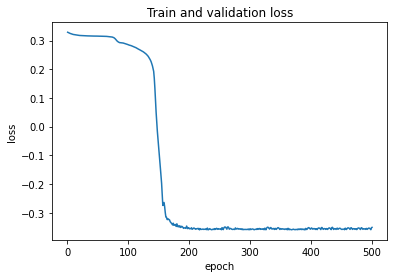

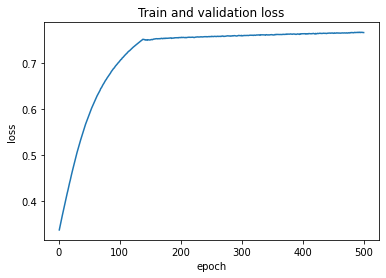

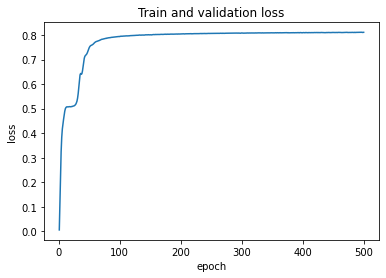

In [369]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train: {} %'.format(100 * correct / total))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))

plot_loss(fc1, num_epochs)
plot_loss(fc2, num_epochs)
plot_loss(fc3, num_epochs)

In [325]:
model8 = Model2(X_train.shape[1]).to(device)
# Loss and optimizer
criterion8 = loss_fn
optimizer8 = [torch.optim.Adam(model8.parameters(), lr=0.01), torch.optim.Adam(model8.parameters(), lr=0.001), torch.optim.Adam(model8.parameters(), lr=0.05)]
num_epochs = 500
fc1, fc2, fc3 = layerwise_train_BIMICE(model8, num_epochs, optimizer8, criterion8)

Training fc1
Epoch [1/500], fc1 BI: 0.3282
Epoch [2/500], fc1 BI: 0.3270
Epoch [3/500], fc1 BI: 0.3259
Epoch [4/500], fc1 BI: 0.3250
Epoch [5/500], fc1 BI: 0.3242
Epoch [6/500], fc1 BI: 0.3235
Epoch [7/500], fc1 BI: 0.3227
Epoch [8/500], fc1 BI: 0.3220
Epoch [9/500], fc1 BI: 0.3214
Epoch [10/500], fc1 BI: 0.3210
Epoch [11/500], fc1 BI: 0.3204
Epoch [12/500], fc1 BI: 0.3199
Epoch [13/500], fc1 BI: 0.3196
Epoch [14/500], fc1 BI: 0.3191
Epoch [15/500], fc1 BI: 0.3190
Epoch [16/500], fc1 BI: 0.3185
Epoch [17/500], fc1 BI: 0.3183
Epoch [18/500], fc1 BI: 0.3179
Epoch [19/500], fc1 BI: 0.3178
Epoch [20/500], fc1 BI: 0.3175
Epoch [21/500], fc1 BI: 0.3174
Epoch [22/500], fc1 BI: 0.3172
Epoch [23/500], fc1 BI: 0.3170
Epoch [24/500], fc1 BI: 0.3168
Epoch [25/500], fc1 BI: 0.3167
Epoch [26/500], fc1 BI: 0.3165
Epoch [27/500], fc1 BI: 0.3163
Epoch [28/500], fc1 BI: 0.3163
Epoch [29/500], fc1 BI: 0.3160
Epoch [30/500], fc1 BI: 0.3159
Epoch [31/500], fc1 BI: 0.3159
Epoch [32/500], fc1 BI: 0.3155
Epoc

Accuracy of the network on the train: 97.5 %
Accuracy of the network on the test: 100.0 %


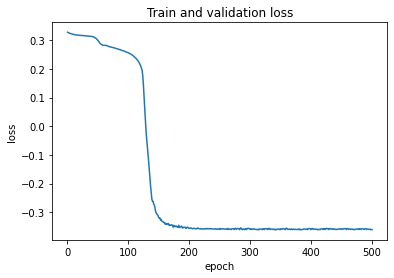

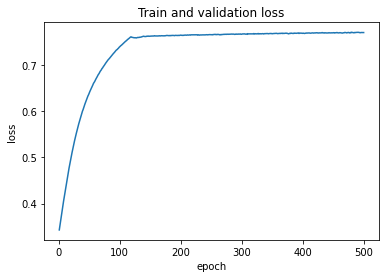

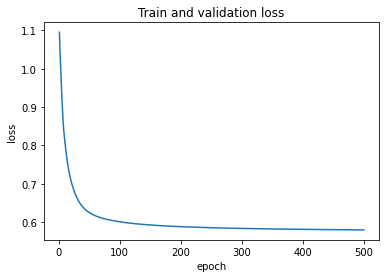

In [326]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model8(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train: {} %'.format(100 * correct / total))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model8(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test: {} %'.format(100 * correct / total))

plot_loss(fc1, num_epochs)
plot_loss(fc2, num_epochs)
plot_loss(fc3, num_epochs)